<a href="https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YoloV3 TF2 GPU Colab Notebook

##### 1.  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 335 (delta 0), reused 0 (delta 0), pack-reused 332
Receiving objects: 100% (335/335), 2.51 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (194/194), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 28.7MB 1.4MB/s 
     |████████████████████████████████| 450kB 66.5MB/s 
     |████████████████████████████████| 3.8MB 52.9MB/s 
     |████████████████████████████████| 81kB 14.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has req

##### 2.  Check Tensorflow2 version

In [2]:
#%cd yolov3-tf2/
!dir

import tensorflow as tf
tf.__version__

 Le volume dans le lecteur D n'a pas de nom.
 Le num‚ro de s‚rie du volume est 3209-620B

 R‚pertoire de D:\github\jupyter\yolov3-tf2

19/07/2020  12:45    <DIR>          .
19/07/2020  12:45    <DIR>          ..
14/07/2020  21:39             2ÿ113 .gitignore
14/07/2020  22:10    <DIR>          .ipynb_checkpoints
14/07/2020  21:39    <DIR>          checkpoints
19/07/2020  12:45         2ÿ504ÿ296 colab_gpu.ipynb
14/07/2020  21:39               167 conda-cpu.yml
14/07/2020  21:39               209 conda-gpu.yml
14/07/2020  21:39             1ÿ318 convert.py
14/07/2020  21:39    <DIR>          data
14/07/2020  21:39             2ÿ623 detect.py
14/07/2020  21:39             3ÿ037 detect_video.py
14/07/2020  21:39    <DIR>          docs
14/07/2020  21:39             1ÿ089 LICENSE
14/07/2020  21:39            13ÿ145 README.md
14/07/2020  22:08                68 requirements-gpu.txt
14/07/2020  21:39                67 requirements.txt
14/07/2020  21:39               232 setup.py
14/07/2020  21

'2.4.0-dev20200716'

##### 3.  Convert Pretrained Darknet Weight

In [7]:
import wget

In [9]:
!python -m wget -o data/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!python convert.py


Saved under data/yolov3.weights
Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, None, None, 5 11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, None, None, 2 2957312     yolo_conv_0[0][0]                
                                                            

2020-07-19 12:53:13.891810: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-07-19 12:53:15.505439: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2020-07-19 12:53:15.520599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 28 deviceMemorySize: 11.00GiB deviceMemoryBandwidth: 451.17GiB/s
2020-07-19 12:53:15.521013: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-07-19 12:53:15.525085: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cublas64_10.dll
2020-07-19 12:53:15.528060: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cufft64_10.d

##### 4. Initialize Detector

In [10]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### 4. Detect Image

I0719 13:06:59.736187  9056 <ipython-input-15-4afc8e106e22>:9] weights loaded
I0719 13:06:59.737179  9056 <ipython-input-15-4afc8e106e22>:12] classes loaded
I0719 13:06:59.801191  9056 <ipython-input-15-4afc8e106e22>:23] time: 0.049132585525512695
I0719 13:06:59.801686  9056 <ipython-input-15-4afc8e106e22>:25] detections:
I0719 13:06:59.804164  9056 <ipython-input-15-4afc8e106e22>:27] 	clock, 0.880177915096283, [0.7482391  0.24570544 0.7872332  0.3025853 ]
I0719 13:06:59.806620  9056 <ipython-input-15-4afc8e106e22>:27] 	pottedplant, 0.7622193694114685, [0.912469   0.3296891  0.9966687  0.53532857]
I0719 13:06:59.808604  9056 <ipython-input-15-4afc8e106e22>:27] 	cup, 0.7267326712608337, [0.68842    0.87792766 0.7265089  0.94155073]
I0719 13:06:59.811579  9056 <ipython-input-15-4afc8e106e22>:27] 	clock, 0.7157813906669617, [0.8052229  0.22516835 0.84459215 0.28169197]
I0719 13:06:59.813563  9056 <ipython-input-15-4afc8e106e22>:27] 	cup, 0.6146554350852966, [0.34895325 0.807332   0.392148

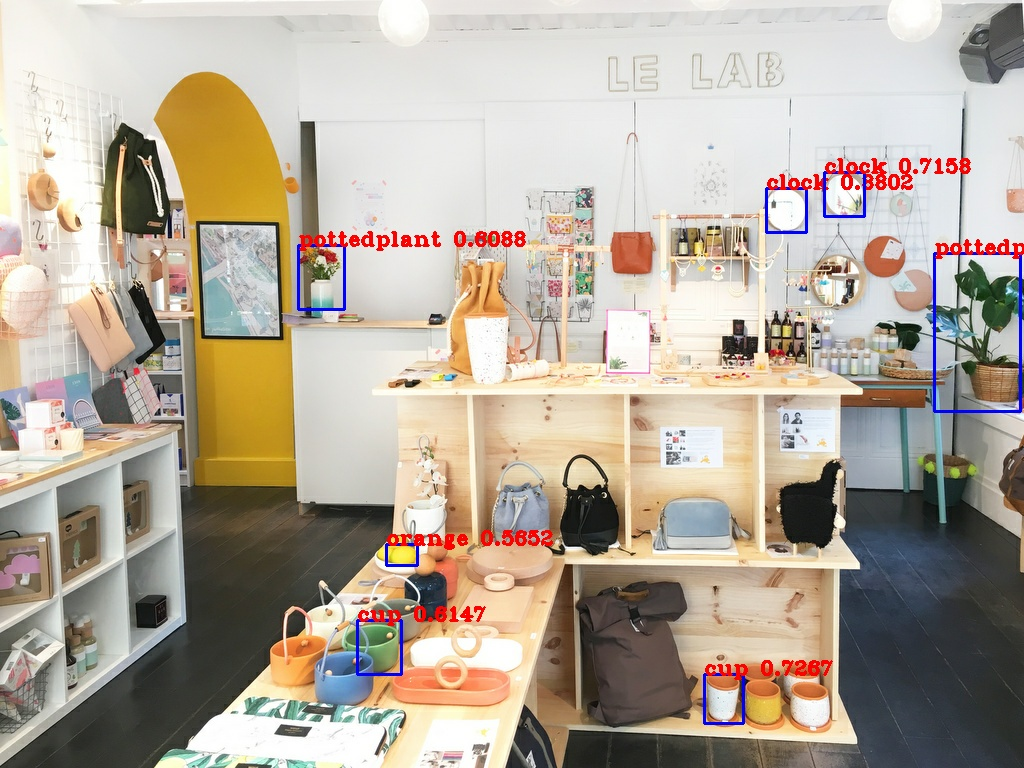

In [15]:
FLAGS.image = 'data/apprt.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

##### 5. Training New Dataset

In [5]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
!mkdir -p ./data/voc2009_raw
!tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw

--2020-02-02 07:42:05--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘./data/voc2009_raw.tar’

./data/voc2009_raw. 100%[===================>] 892.19M  12.8MB/s    in 70s     

2020-02-02 07:43:15 (12.8 MB/s) - ‘./data/voc2009_raw.tar’ saved [935534080/935534080]



In [6]:
!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2020-02-02 07:43:26.544079: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:26.544194: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:26.544212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0202 07:43:27.628061 140379651344256 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 1

In [7]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

2020-02-02 07:43:41.774830: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:41.774936: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:43:41.774955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0202 07:43:42.585982 139924403734400 visualize_dataset.py:22] classes loaded
2020-02-02 07:43:42.739779: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because t

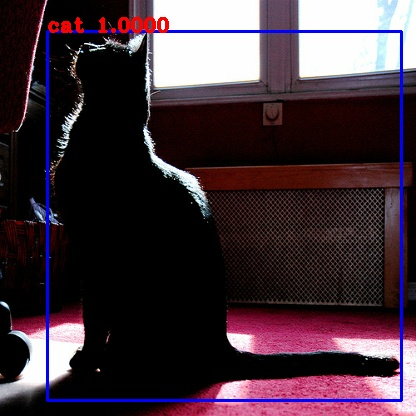

In [8]:
from IPython.display import Image
Image(filename='./output.jpg')

In [9]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2020-02-02 07:44:14.946313: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:44:14.946449: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-02 07:44:14.946465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Epoch 1/3
2020-02-02 07:44:51.124510: W tensorflow/core/common_runtime/bfc_allocator.cc:309] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to

##### 6. Detect using new weights

80
checkpoints/yolov3_train_3.tf
False


I0202 08:07:54.499751 139839832848256 <ipython-input-23-b2060d0f067f>:20] weights loaded
I0202 08:07:54.501296 139839832848256 <ipython-input-23-b2060d0f067f>:23] classes loaded
I0202 08:07:54.765269 139839832848256 <ipython-input-23-b2060d0f067f>:34] time: 0.22004270553588867
I0202 08:07:54.766204 139839832848256 <ipython-input-23-b2060d0f067f>:36] detections:
I0202 08:07:54.773281 139839832848256 <ipython-input-23-b2060d0f067f>:40] 	person, 0.20115408301353455, [0.2177423  0.2220931  0.95681787 0.77683055]


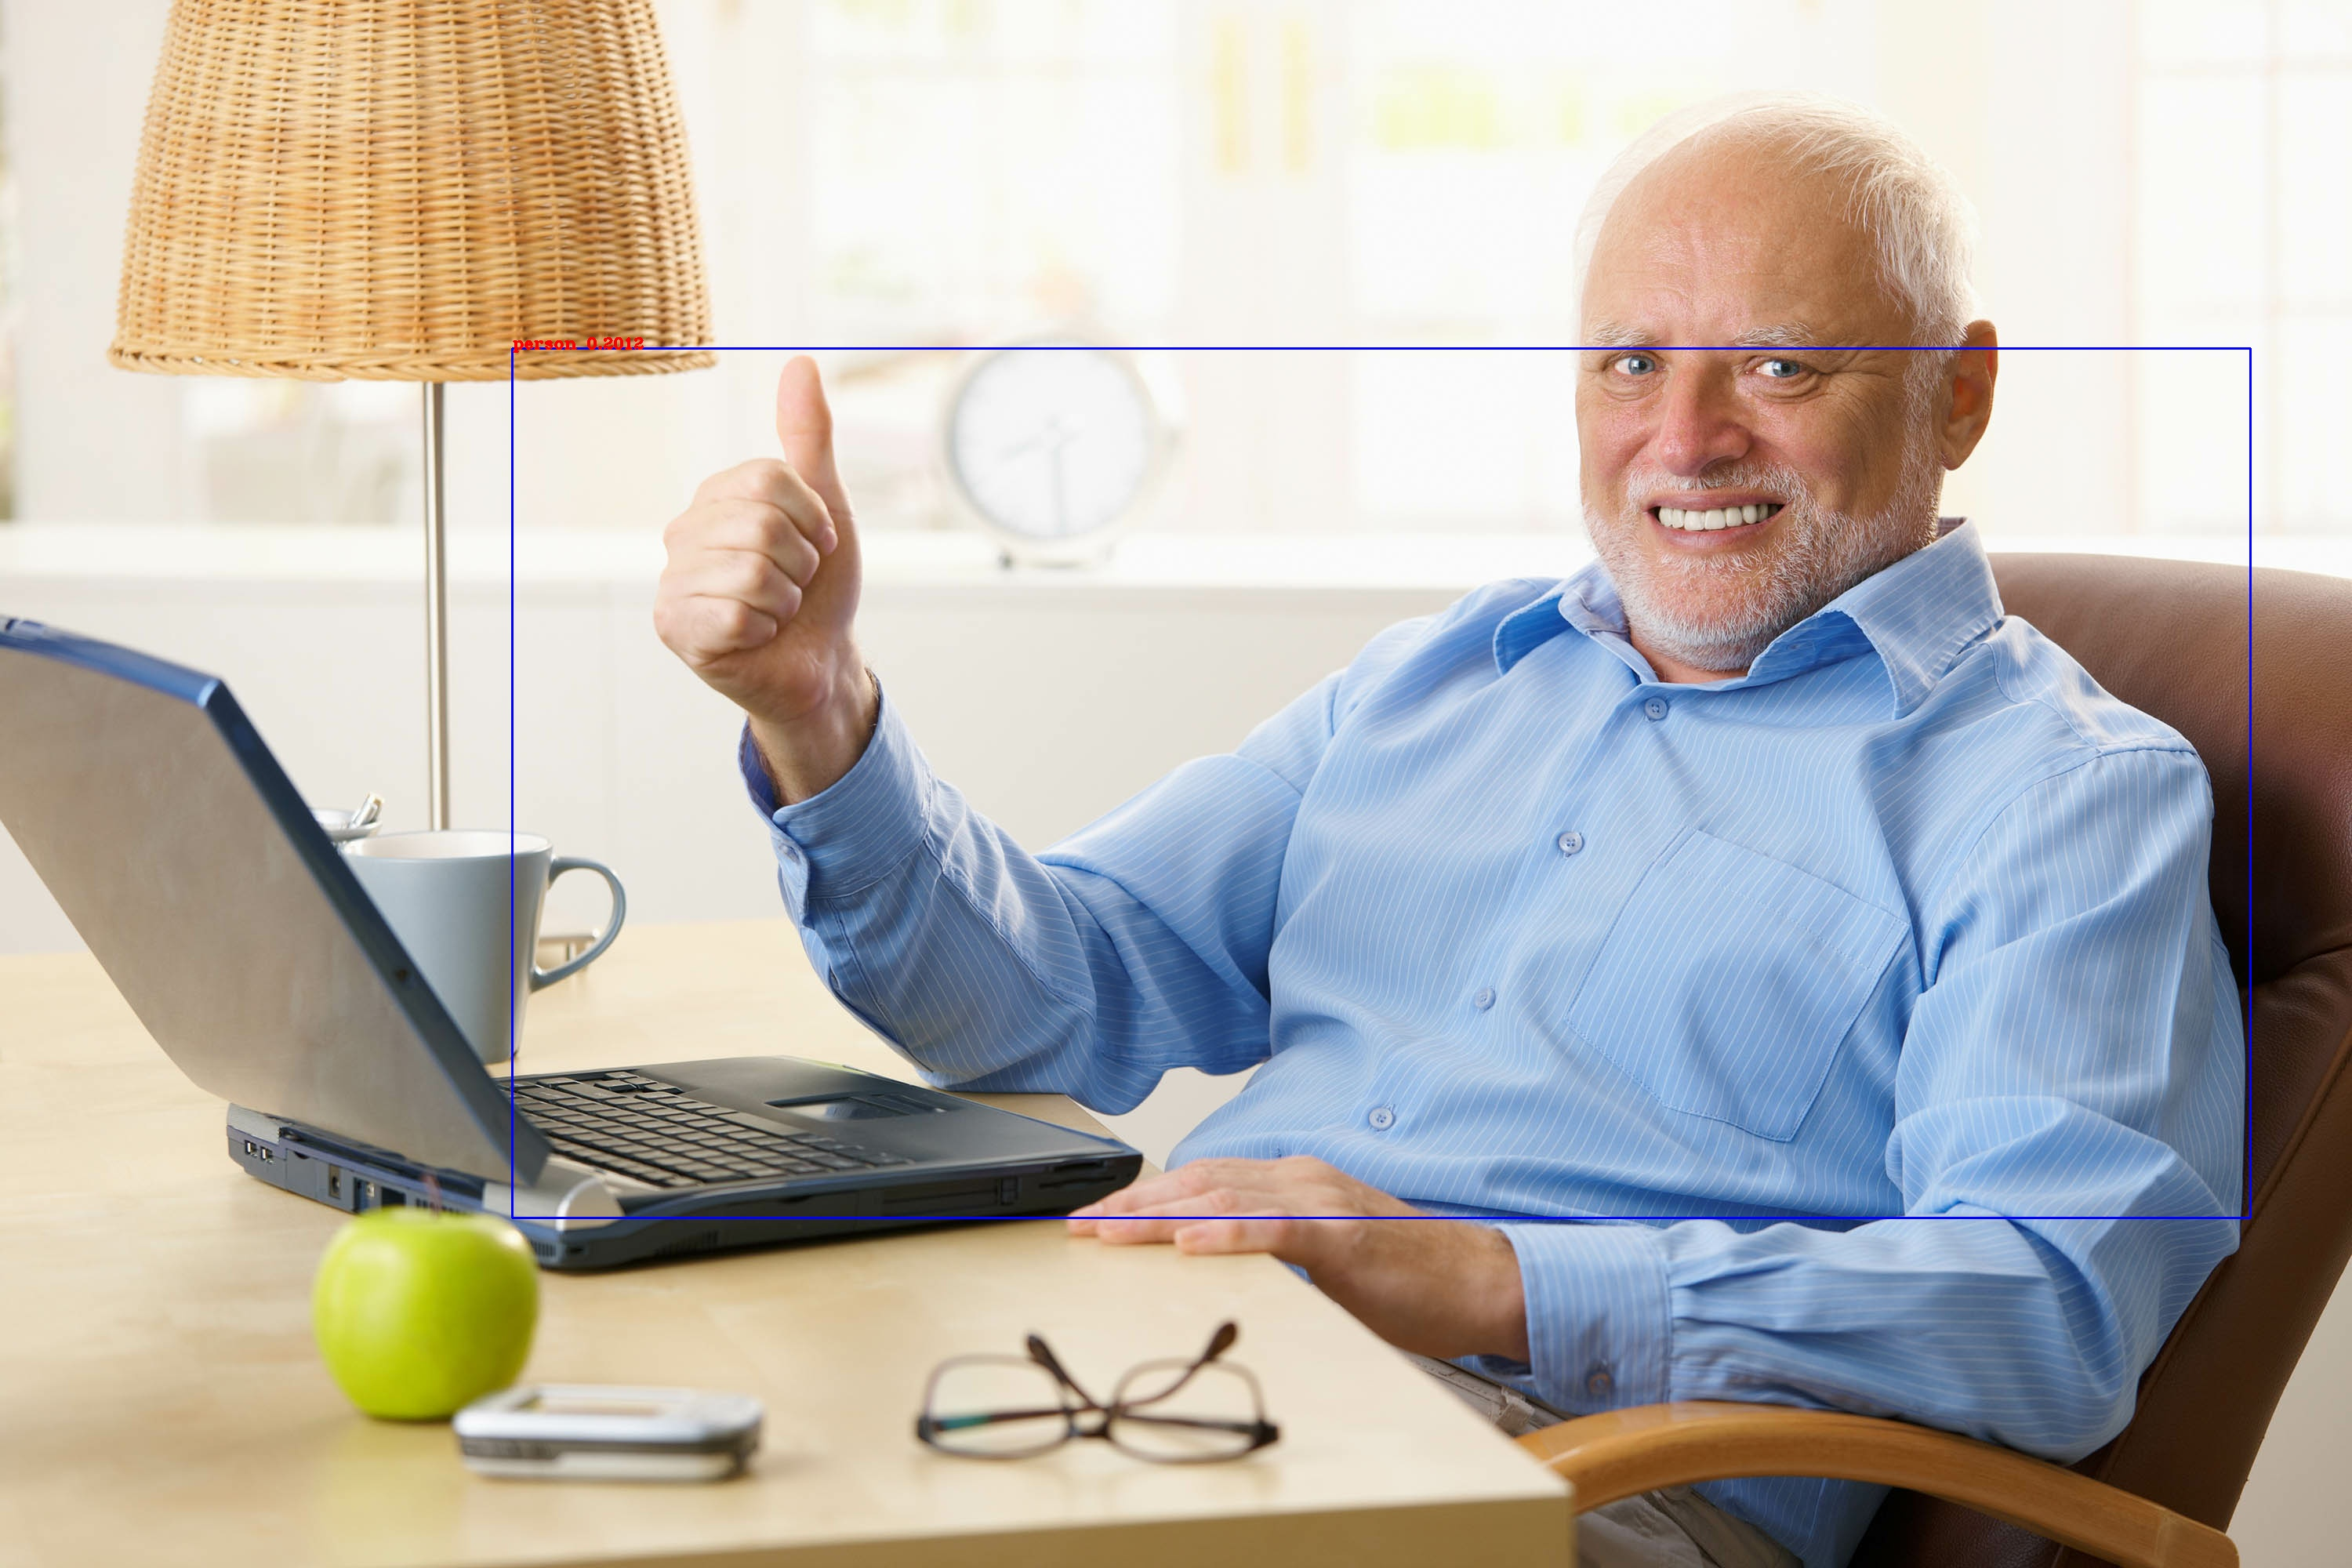

In [23]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
FLAGS.image = 'data/meme.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))